# Assignment 3: Character-Level Recurrent Neural Network by PyTorch

In this assignment, you are required to implement Character-Level RNN just as we have learned in the class. However, the difference is we use another dataset in this assignment.

Read through the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) that builds a char-rnn that is used to classify names by their country of origin, which is introduced in the class. It is recommended that you can reproduce the tutorial’s results on the provided name dataset before moving on (notebook for Lecture 7), since the neural network architectures remain largely the same. Make sure you try your best to understand the dimensions of each layer (e.g. which ones can stay the same, and which are hyperparameters for us to tweak).

The process will be broken down into the following steps:
>1. Code implementation. (20 marks)
2. Experimentation and analysis (80 marks)

In [457]:
#Download and unzip files
!pip3 install scikit-learn
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip 
!unzip cities_train.zip 
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torch torchvision
  
import torch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

--2020-11-15 07:37:18--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10973 (11K) [text/plain]
Saving to: ‘cities_test.txt’

cities_test.txt     100%[===================>]  10.72K  --.-KB/s    in 0s      

2020-11-15 07:37:18 (136 MB/s) - ‘cities_test.txt’ saved [10973/10973]

--2020-11-15 07:37:19--  http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7558 (7.4K) [application/zip]
Sav

In [458]:
#Verfiy file download
!head train/af.txt
!printf "\n"
!head val/af.txt
!printf "\n"
!head cities_test.txt
!printf "\n"
#Verify CUDA acceleration should print cuda:0
print(device)

garavshakh
kalishli
sarban kelay
dahan-e surunah
jahannum
morafeno
iskatel
zeri-chinar
taftebole
dzhafarabat

sikhtopa
laferronay
cham ghafur
souk tafetecht
panqash
siah sar bala
barah khan kili
vetob
kacari
kolga'i-i-bala

imam bakhsh amar
firoz laghari
glufishevo
qal`eh-ye ghazanfarkhani
nikolinalevada
kolkko
mbrostar i fierit
kharabanan-e sofla
stein bei nurnberg
jahangir bara

cuda:0


In [459]:
def get_file_code(filename):
     # 采样长度,最长采样长度为100，可调节
    sample_len = min( 100, os.path.getsize(filename))
    #读取片段bytes 
    raw = open(filename, 'rb').read(sample_len)
    #检测编码
    detect = chardet.detect(raw)
    return detect['encoding']

In [465]:
def make_file_utf8():
    for filename in ('train', 'val'):
        for lang in languages:
            path = os.path.join("./", filename, f'{lang}.txt')
            with codecs.open(path, "r", encoding='utf-8', errors='ignore') as fdata:
                data = fdata.read()
            fdata.close()
            with open(path, 'w') as f:
                print(data, file=f, end='')
            f.close()
    path = "./cities_test.txt"
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as fdata:
        data = fdata.read()
    fdata.close()
    with open(path, 'w') as f:
        print(data, file=f, end='')
    f.close()

## Code Implementation (20 marks)

**You should implement all the following functions and you are not allowed to delete any of them. Of course you can add more functions based on this skeleton.**

In [258]:
#main_classify.py
import codecs
import math
import random
import string
import time
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from io import open
import unicodedata
import sys

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
len_all_letters = len(all_letters)
len_languages = len(languages)

'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A nx1 array containing the words of the specified language
'''
def getWords(baseDir, lang, train = True):
    filename = baseDir + ("train/" if train else "val/") + lang + ".txt"
    lines = open(filename, "r", encoding="utf-8", errors='ignore').read().strip().split('\n')
    return np.array([unicodeToAscii(line) for line in lines])

'''
Returns a label corresponding to the language
For example it returns an array of 0s for af
Return: A nx1 array as integers containing index of the specified language in the "languages" array
'''
def getLabels(lang, length):
    return np.ones(length, dtype=np.int)*languages.index(lang)

'''
Returns all the laguages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is nx1 and y is nx1
'''
def readData(baseDir, train=True):
    languages_lines = []
    label_lines = []
    for lang in languages:
        language_words = getWords(baseDir, lang, train)
        languages_lines = np.concatenate((languages_lines,language_words))
        label_lines = np.concatenate((label_lines,getLabels(lang,len(language_words))))
    return languages_lines, label_lines.astype(int)

'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''
def line_to_tensor(line):
    len_line = len(line)
    if len_line==1:
        tensor = torch.zeros(1, len_all_letters)
        tensor[0][all_letters.find(line)] = 1
        return tensor
    else:
        tensor = torch.zeros(len(line), 1, len_all_letters)
        for li, letter in enumerate(line):
            tensor[li][0][all_letters.find(letter)] = 1
        return tensor
'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities)
Return: A tuple with (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return languages[category_i], category_i

'''
Get a random input output pair to be used for training 
Refer the tutorial in the spec
'''
def random_training_pair(X, y):
    rand_idx = random.randint(0,len(X)-1)
    return X[rand_idx],y[rand_idx]
'''
Input: trained model, a list of words, a list of class labels as integers
Output: a list of class labels as integers
'''
def predict(model, X, y):
    labels_res = []
#     X_del = [line_to_tensor(item) for item in X]
    X_del = [[line_to_tensor(iitem) for iitem in item] for item in X]
    with torch.no_grad():
        for i in range(len(X_del)):
            hidden = model.init_hidden()
            for j in range(X_del[i]):
                output, hidden = model(X_del[i][j], hidden)
            _, op = category_from_output(output)
            labels_res.append(op)
    return labels_res

'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
#     X_del = [line_to_tensor(item) for item in X]
    X_del = [[line_to_tensor(iitem) for iitem in item] for item in X]
    y_del = [torch.tensor([item], dtype=torch.long) for item in y]
    X_len = len(X_del)
    cur_acc = 0
    cur_loss = 0
    with torch.no_grad():
        for i in range(X_len):
            hidden = model.init_hidden()
            for j in range(len(X_del[i])):
                output, hidden = model(X_del[i][j], hidden)
            _, op = category_from_output(output)
            loss = criterion(output, y_del[i])
            cur_loss += loss*1.0/X_len
            if(y[i] == op):
                cur_acc += 1.0/X_len
    return cur_acc, cur_loss

'''
Train the model for one epoch/one training word.
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''
def trainOneEpoch(model, criterion, optimizer, X, y):
    input_line, target = random_training_pair(X, y)    
    target = torch.tensor([target], dtype=torch.long)
    
    hidden = model.init_hidden()
    
    for i in range(len(input_line)):
        output, hidden = model(line_to_tensor(input_line[i]), hidden)
    loss = criterion(output, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, target, loss.item()
    
'''
Use this to train and save your classification model. 
Save your model with the filename "model_classify"
'''
def run():
    n_iters = 100000*5
    print_every = 5000
    cur_acc = 0
    cur_loss = 0
    
    X_train, y_train = readData("./", True)
    X_val, y_val = readData("./", False)
    
    for ite in range(n_iters):
        output, target, loss = trainOneEpoch(model, criterion, optimizer, X_train, y_train)
        cur_loss += loss*1.0/print_every
        guess, guess_i = category_from_output(output)
        if (guess_i == target):
            cur_acc += 1.0/print_every
            
        if ( (ite+1) % print_every == 0):
            val_acc, val_loss = calculateAccuracy(model, X_val, y_val)
            if (verbose==1):
                print('iter:%d train_loss:%f train_acc:%f val_loss:%f val_acc:%f' % ((ite+1), cur_loss, cur_acc, val_loss, val_acc))
            
            all_train_losses.append(cur_loss)
            all_train_acc.append(cur_acc)
            
            all_val_losses.append(val_loss)
            all_val_acc.append(val_acc)
            
            cur_acc, cur_loss = 0, 0
            
    torch.save(model, 'model_classify.pkl')

'''
Transform the unicode encoding word into ascii encoding
'''
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

'''
Read single test data
test data without labeled
'''
def readTestData(filename):
    lines = open(filename, "r", encoding="utf-8", errors='ignore').read().strip().split('\n')
    return np.array([unicodeToAscii(line) for line in lines])


'''
Initial the data
'''
def init():
    global all_train_losses, all_train_acc, all_val_losses, all_val_acc
    all_train_losses = []
    all_train_acc = []
    all_val_losses = []
    all_val_acc = []

In [259]:
#models.py
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F

'''
Please add default values for all the parameters of __init__.
'''
class CharRNNClassify(nn.Module):
    def __init__(self, input_size=57, hidden_size=128, output_size=8):
        super(CharRNNClassify, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden=None):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.relu(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [260]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

In [261]:
input_size = len_all_letters
hidden_size = 256
output_size = len_languages
model = CharRNNClassify(input_size, hidden_size, output_size)
criterion = nn.NLLLoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
all_train_losses = []
all_train_acc = []
all_val_losses = []
all_val_acc = []

verbose = 1

In [262]:
run()

iter:5000 train_loss:2.099703 train_acc:0.230800 val_loss:1.973514 val_acc:0.281111
iter:10000 train_loss:1.843470 train_acc:0.363600 val_loss:1.722629 val_acc:0.404444
iter:15000 train_loss:1.677909 train_acc:0.399400 val_loss:1.649550 val_acc:0.434444
iter:20000 train_loss:1.596584 train_acc:0.437000 val_loss:1.566831 val_acc:0.453333
iter:25000 train_loss:1.526990 train_acc:0.465400 val_loss:1.508171 val_acc:0.480000
iter:30000 train_loss:1.447991 train_acc:0.496400 val_loss:1.463863 val_acc:0.474444
iter:35000 train_loss:1.405237 train_acc:0.511600 val_loss:1.417793 val_acc:0.504444
iter:40000 train_loss:1.346588 train_acc:0.535400 val_loss:1.370992 val_acc:0.517778
iter:45000 train_loss:1.303967 train_acc:0.550000 val_loss:1.341744 val_acc:0.524444
iter:50000 train_loss:1.235356 train_acc:0.578800 val_loss:1.315031 val_acc:0.555556
iter:55000 train_loss:1.194084 train_acc:0.606000 val_loss:1.289931 val_acc:0.558889
iter:60000 train_loss:1.153737 train_acc:0.615200 val_loss:1.23966

In [237]:
# X = readTestData("./cities_test.txt")
# model = torch.load('model_classify.pkl')
# predict(model, X, None)

In [238]:
# X, y = readData("./", True)
# model = torch.load('model_classify.pkl')
# calculateAccuracy(model, X, y)

## Experimentation and Analysis (80 marks)

Complete the following analysis on the city names dataset.

1. Write code to output accuracy on the validation set (10 marks).  Use a confusion matrix plot to support your answer (10 marks).

In [239]:
def evaluate(model, X, y):
    confusion = torch.zeros(len_languages, len_languages)
    
    X_del = [[line_to_tensor(iitem) for iitem in item] for item in X]
    y_del = [torch.tensor([item], dtype=torch.long) for item in y]
    with torch.no_grad():
        for i in range(len(X_del)):
            hidden = model.init_hidden()
            for j in range(len(X_del[i])):
                output, hidden = model(X_del[i][j], hidden)
            _, op = category_from_output(output)
            confusion[y[i]][op] += 1
            
    return confusion, len(X_del)

In [270]:
X_val, y_val = readData("./", False)
model = torch.load('model_classify.pkl')
calculateAccuracy(model, X_val, y_val)

(0.6677777777777725, tensor(1.0432))

In [241]:
# Keep track of correct guesses in a confusion matrix
confusion, n_confusion = evaluate(model, X_val, y_val)

In [242]:
# Normalize by dividing every row by its sum
for i in range(len_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

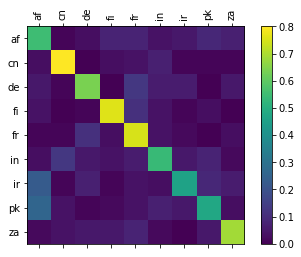

In [243]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

2. Periodically compute the loss on the validation set, and create a plot with the training and validation loss as training progresses (20 marks).

In [263]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def display_curves(data_list, label_list, title, subplot):
    ax = plt.subplot(subplot)
    for item in data_list:
        ax.plot(item)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(label_list)

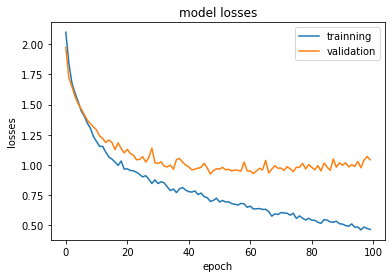

In [264]:
# plt.subplots(figsize=(5,5))
# plt.tight_layout()
display_curves([all_train_losses,all_val_losses], ["trainning","validation"], "losses",111)

3. Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. Another common practice is to drop the learning rate when the loss has plateaued. Use plots to explain your experiments and their effects on the loss (20 marks).

In [256]:
all_lr_train_losses = []
all_lr_val_losses = []

lr_list = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6]
for lr_item in lr_list:
    verbose = 1
    model = CharRNNClassify(input_size, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_item)
    init()
    run()
    all_lr_train_losses.append(all_train_losses)
    all_lr_val_losses.append(all_val_losses)

iter:5000 train_loss:2.239788 train_acc:0.314400 val_loss:1.856678 val_acc:0.352222
iter:10000 train_loss:1.670412 train_acc:0.434000 val_loss:3.938285 val_acc:0.503333
iter:15000 train_loss:1.717032 train_acc:0.494000 val_loss:1.989165 val_acc:0.482222
iter:20000 train_loss:1.469065 train_acc:0.534800 val_loss:1.491950 val_acc:0.494444
iter:25000 train_loss:24.845298 train_acc:0.541400 val_loss:1.497587 val_acc:0.516667
iter:30000 train_loss:1.339479 train_acc:0.578600 val_loss:1.386725 val_acc:0.525556
iter:35000 train_loss:1.289745 train_acc:0.607600 val_loss:1.552654 val_acc:0.488889
iter:40000 train_loss:1.313970 train_acc:0.576400 val_loss:1.401900 val_acc:0.542222
iter:45000 train_loss:1.261917 train_acc:0.598600 val_loss:1.504083 val_acc:0.504444
iter:50000 train_loss:1.364096 train_acc:0.562600 val_loss:1.519047 val_acc:0.494444
iter:55000 train_loss:1.274168 train_acc:0.595600 val_loss:1.497314 val_acc:0.521111
iter:60000 train_loss:1.276626 train_acc:0.594200 val_loss:1.4536

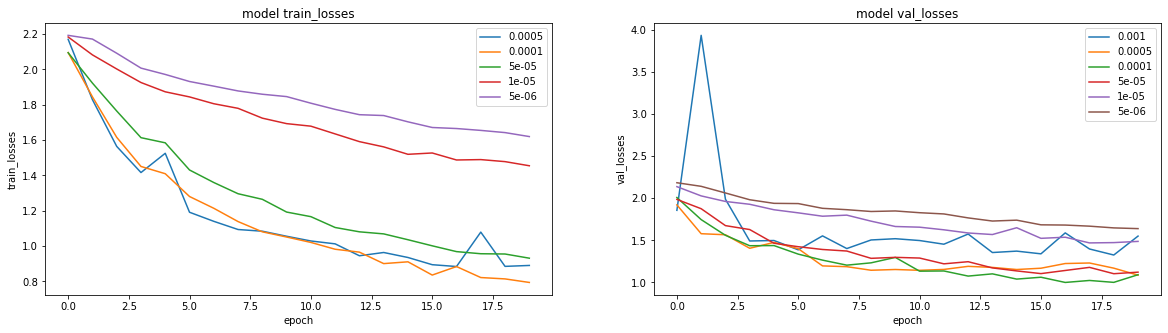

In [257]:
plt.subplots(figsize=(20,5))
display_curves(all_lr_train_losses[1:], [str(item) for item in lr_list][1:], "train_losses", 121)
display_curves(all_lr_val_losses, [str(item) for item in lr_list], "val_losses", 122)

4. Experiment with the size of the hidden layer or the model architecture How does this affect validation accuracy (20 marks)?

In [252]:
all_lr_train_losses = []
all_lr_val_losses = []

hidden_list = [32,64,128,256,512,1024]
for hidden_item in hidden_list:
    hidden_size = hidden_item
    verbose = 1
    model = CharRNNClassify(input_size, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    init()
    run()
    all_lr_train_losses.append(all_train_losses)
    all_lr_val_losses.append(all_val_losses)

iter:5000 train_loss:2.183159 train_acc:0.134400 val_loss:2.163373 val_acc:0.204444
iter:10000 train_loss:2.108699 train_acc:0.240000 val_loss:2.038791 val_acc:0.225556
iter:15000 train_loss:1.994762 train_acc:0.279200 val_loss:1.987802 val_acc:0.311111
iter:20000 train_loss:1.949808 train_acc:0.323800 val_loss:1.940964 val_acc:0.316667
iter:25000 train_loss:1.910294 train_acc:0.347800 val_loss:1.897284 val_acc:0.356667
iter:30000 train_loss:1.863206 train_acc:0.358800 val_loss:1.841633 val_acc:0.371111
iter:35000 train_loss:1.807417 train_acc:0.389800 val_loss:1.779553 val_acc:0.376667
iter:40000 train_loss:1.723894 train_acc:0.399600 val_loss:1.734074 val_acc:0.387778
iter:45000 train_loss:1.670944 train_acc:0.426800 val_loss:1.688912 val_acc:0.407778
iter:50000 train_loss:1.601790 train_acc:0.442800 val_loss:1.629531 val_acc:0.412222
iter:55000 train_loss:1.558990 train_acc:0.454000 val_loss:1.646836 val_acc:0.417778
iter:60000 train_loss:1.537903 train_acc:0.466400 val_loss:1.59531

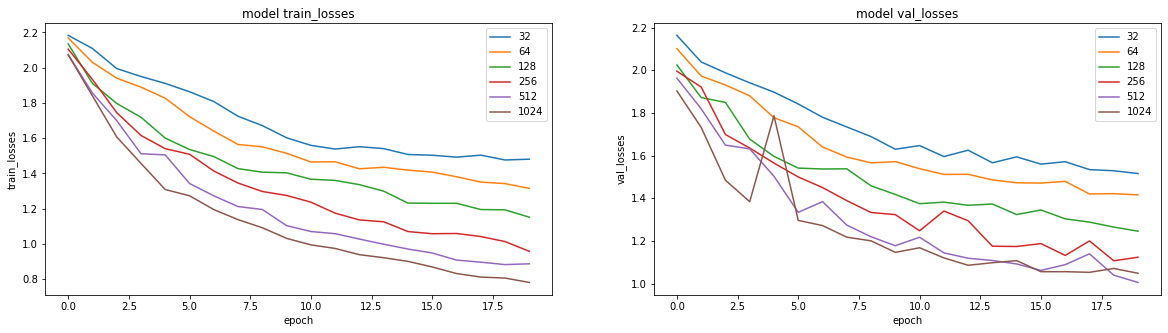

In [253]:
plt.subplots(figsize=(20,5))
display_curves(all_lr_train_losses, [str(item) for item in hidden_list], "train_losses", 121)
display_curves(all_lr_val_losses, [str(item) for item in hidden_list], "val_losses", 122)